## Load Data

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import shutil
import os

source_files = ['/content/drive/MyDrive/BCL/hw3/spikes.mat', '/content/drive/MyDrive/BCL/hw3/zebra_finch_data.mat']
destination_dir = '/content'

for file in source_files:
  if os.path.exists(file):
    try:
      shutil.copy2(file, destination_dir)
      print(f"Successfully copied '{file}' to '{destination_dir}'")
    except shutil.SameFileError:
      print(f"Source and destination represent the same file: '{file}'")
    except PermissionError:
      print(f"Permission denied while copying '{file}'")
    except Exception as e:
      print(f"An error occurred while copying '{file}': {e}")
  else:
    print(f"File '{file}' does not exist.")

Successfully copied '/content/drive/MyDrive/BCL/hw3/spikes.mat' to '/content'
Successfully copied '/content/drive/MyDrive/BCL/hw3/zebra_finch_data.mat' to '/content'


## Import Libraries

In [ ]:
import scipy.io
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import butter, filtfilt, find_peaks
from sklearn.decomposition import PCA

## Reading Data

In [ ]:
zebra_finch_data = scipy.io.loadmat('zebra_finch_data.mat')
spikes_data = scipy.io.loadmat('spikes.mat')

In [ ]:
zebra_finch_data

{'__header__': b'MATLAB 5.0 MAT-file, Platform: PCWIN64, Created on: Sat Nov  2 22:40:00 2024',
 '__version__': '1.0',
 '__globals__': [],
 'events': array([[  2892,      2],
        [  7412,      2],
        [ 12833,      1],
        [ 17623,      1],
        [ 22823,      1],
        [ 27613,      1],
        [ 31583,      1],
        [ 35981,      3],
        [ 41931,      2],
        [ 47481,      2],
        [ 53170,      2],
        [ 59482,      1],
        [ 64402,      1],
        [ 68060,      2],
        [ 73200,      2],
        [ 78920,      3],
        [ 84630,      2],
        [ 89930,      3],
        [ 96701,      1],
        [102479,      2],
        [109019,      3],
        [115751,      1],
        [120499,      3],
        [127819,      2],
        [134559,      2],
        [141288,      2],
        [148248,      2],
        [155600,      1],
        [160330,      1],
        [164858,      2],
        [171198,      2],
        [178118,      2],
        [184937,   

In [ ]:
fs = zebra_finch_data['fs'].flatten()[0]
events = zebra_finch_data['events']
zebra_raw_signal = zebra_finch_data['rawSig']

In [ ]:
print(zebra_raw_signal)

[[   0.      0.      0.   ... -124.75 -122.   -123.25]]


In [ ]:
zebra_raw_signal = zebra_raw_signal[0]

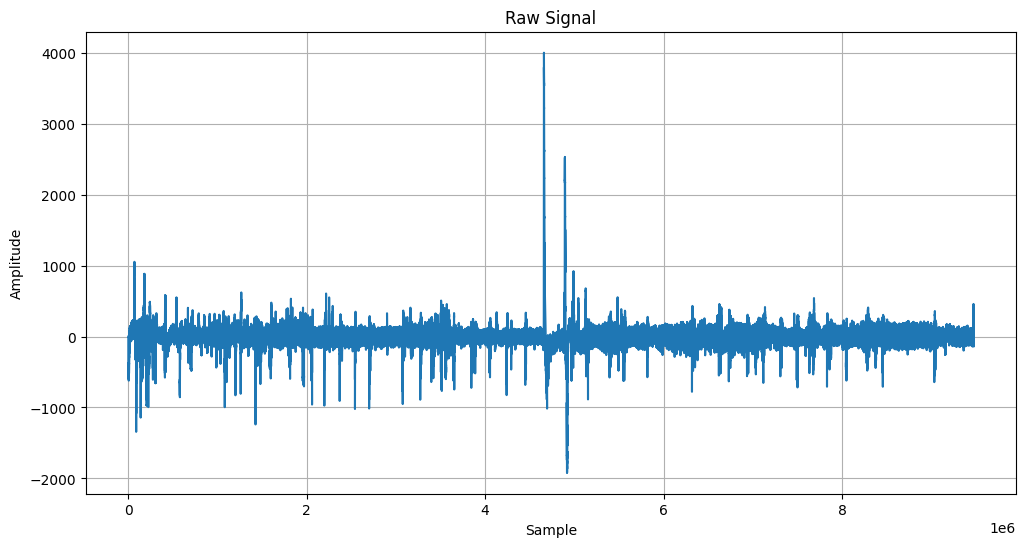

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(zebra_raw_signal)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Raw Signal')
plt.grid(True)
plt.show()

In [ ]:
spikes_raw_data = spikes_data['Spikes']

spikes_raw_data = spikes_raw_data.T

spikes_raw_data

array([[ 0.06736427,  0.10319504,  0.14366583, ..., -0.07354728,
        -0.07445257, -0.06696428],
       [ 0.08074824,  0.04240265,  0.01714091, ..., -0.10677961,
        -0.105025  , -0.09857577],
       [ 0.07754885,  0.11202668,  0.14353827, ..., -0.03628541,
        -0.05129527, -0.05895303],
       ...,
       [-0.00138719, -0.01693153, -0.03298133, ..., -0.05829655,
        -0.07335878, -0.07888557],
       [-0.08972423, -0.07206191, -0.0496478 , ...,  0.0142151 ,
         0.0048625 , -0.0070071 ],
       [ 0.05689439,  0.0387529 ,  0.01933055, ...,  0.05221106,
         0.02327442,  0.00771507]])

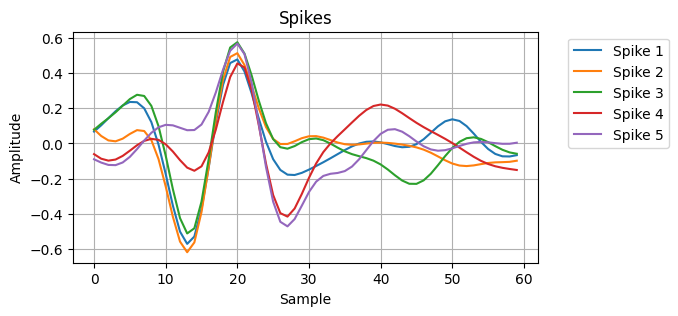

In [ ]:
plt.figure(figsize=(6, 3))
plt.plot(spikes_raw_data[0], label='Spike 1')
plt.plot(spikes_raw_data[1], label='Spike 2')
plt.plot(spikes_raw_data[2], label='Spike 3')
plt.plot(spikes_raw_data[3], label='Spike 4')
plt.plot(spikes_raw_data[4], label='Spike 5')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Spikes')
plt.grid(True)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [ ]:
max_amp_indices = np.argmax(spikes_raw_data, axis=1)
mean_max_amp_index = np.mean(max_amp_indices)

print(f"Mean of max amplitude indices: {mean_max_amp_index}")

Mean of max amplitude indices: 20.0


In [ ]:
spikes_raw_data.shape

(460, 60)

## Preprocessing

In [ ]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

In [ ]:
b, a = butter_highpass(250, fs, order=5)
zebra_filtered_signal = filtfilt(b, a, zebra_raw_signal)

b, a = butter_lowpass(3000, fs, order=5)
zebra_filtered_signal = filtfilt(b, a, zebra_filtered_signal)

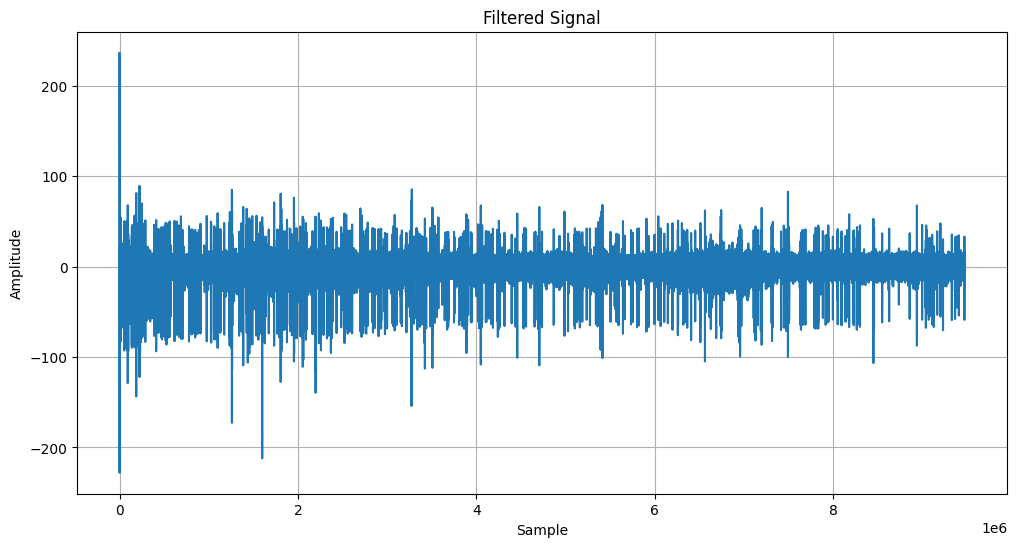

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(zebra_filtered_signal)
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Filtered Signal')
plt.grid(True)
plt.show()

In [ ]:
std_signal = np.std(zebra_filtered_signal)
min_peak_height = 3 * std_signal
min_peak_distance = int(fs / 1000)

In [ ]:
zebra_peaks, _ = find_peaks(zebra_filtered_signal, height=min_peak_height, distance=min_peak_distance)

In [ ]:
print(zebra_peaks)

[     97     157     796 ... 9469974 9470029 9473427]


In [ ]:
print(len(zebra_peaks))

4891


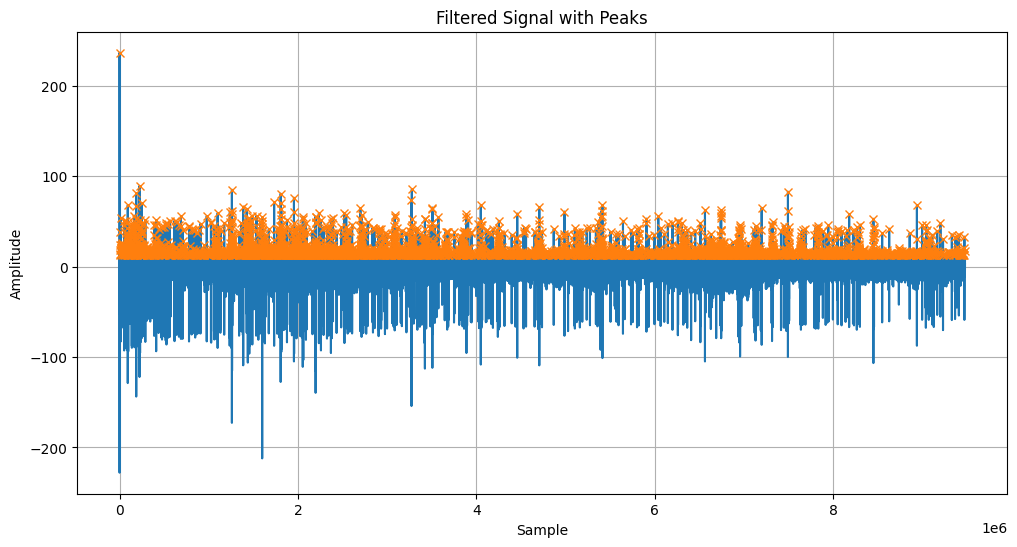

In [ ]:
plt.figure(figsize=(12, 6))
plt.plot(zebra_filtered_signal)
plt.plot(zebra_peaks, zebra_filtered_signal[zebra_peaks], "x")
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Filtered Signal with Peaks')
plt.grid(True)

plt.show()

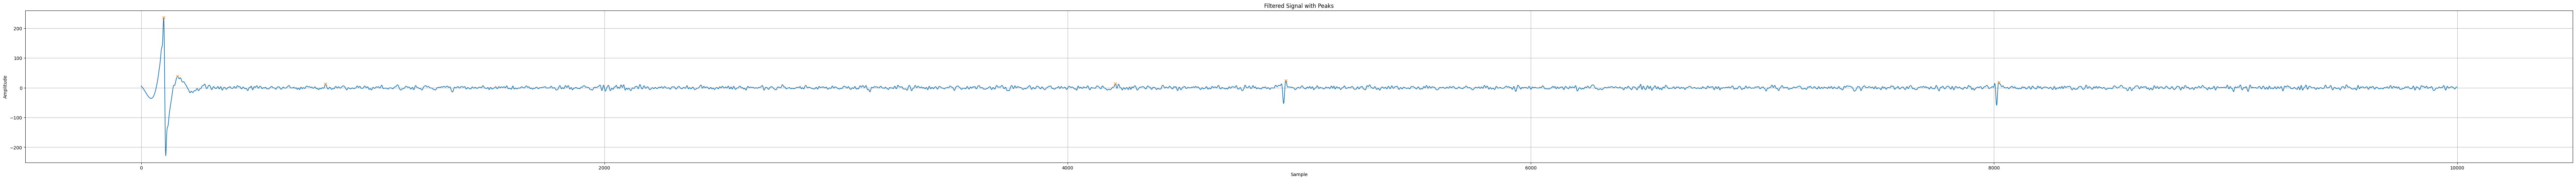

In [ ]:
len_signal = 10000
plt.figure(figsize=(100, 6))
plt.plot(zebra_filtered_signal[:len_signal])
plt.plot(zebra_peaks[zebra_peaks < len_signal], zebra_filtered_signal[zebra_peaks[zebra_peaks < len_signal]], "x")
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Filtered Signal with Peaks')
plt.grid(True)

plt.show()

In [ ]:
zebra_peaks_array = []

for peak in zebra_peaks:
    time_points = zebra_filtered_signal[peak - 20: peak + 40]  # 60 time points around the spike
    zebra_peaks_array.append(time_points)

zebra_peaks_array = np.array(zebra_peaks_array)

print(zebra_peaks_array)

[[ 57.93844399  63.29546169  68.55698543 ... -19.85810192 -14.27595246
   -8.535415  ]
 [ -3.00189134   1.81265392   5.42838882 ...   8.32808908   6.95006777
    5.34611457]
 [ -3.64040852  -3.77794639  -3.43693858 ...  -3.2062164   -2.43956365
   -1.23391885]
 ...
 [  3.64243489   4.97158104   5.52713905 ...   5.52613932   9.55607361
   11.45000223]
 [ -3.4574921    0.79469375   5.52613932 ...  -3.12897809  -3.21489009
   -3.06797801]
 [  0.57268286  -0.273294    -0.70908177 ...  -0.57039084  -1.95085788
   -3.48025228]]


In [ ]:
zebra_peaks_array.shape

(4891, 60)

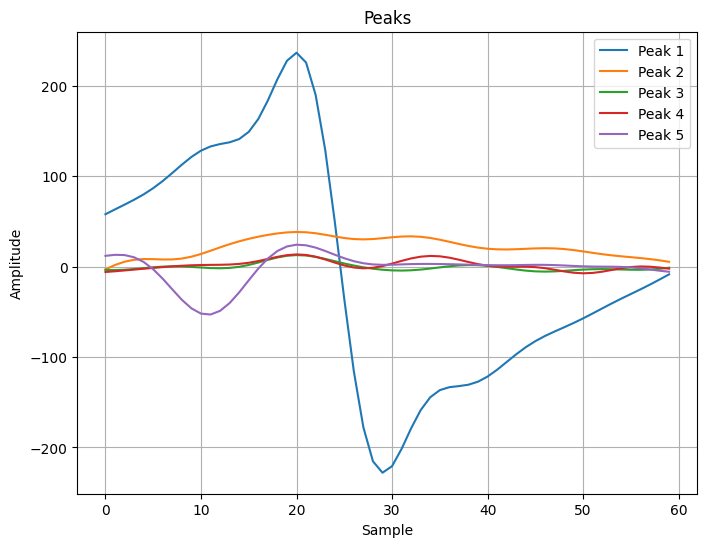

In [ ]:
plt.figure(figsize=(8, 6))
plt.plot(zebra_peaks_array[0], label='Peak 1')
plt.plot(zebra_peaks_array[1], label='Peak 2')
plt.plot(zebra_peaks_array[2], label='Peak 3')
plt.plot(zebra_peaks_array[3], label='Peak 4')
plt.plot(zebra_peaks_array[4], label='Peak 5')
plt.xlabel('Sample')
plt.ylabel('Amplitude')
plt.title('Peaks')
plt.grid(True)
plt.legend()
plt.show()

## PCA

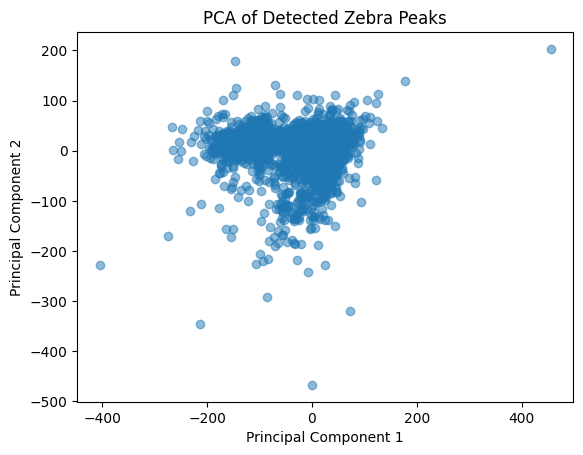

In [ ]:
pca = PCA(n_components=2)
zebra_pca_result = pca.fit_transform(zebra_peaks_array)

plt.scatter(zebra_pca_result[:, 0],zebra_pca_result[:, 1], alpha=0.5)
plt.title('PCA of Detected Zebra Peaks')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

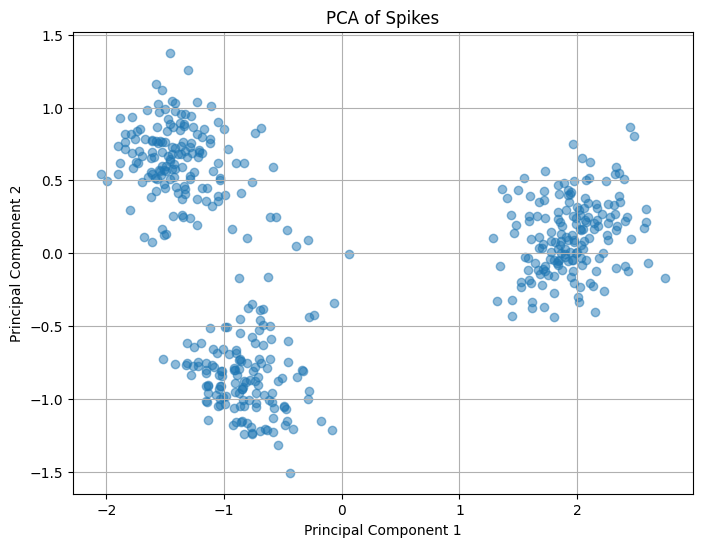

In [ ]:
pca = PCA(n_components=2)
pca_result = pca.fit_transform(spikes_raw_data)

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], alpha=0.5)
plt.title('PCA of Spikes')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.grid(True)
plt.show()

## Classification

### Kmeans

In [ ]:
class KMeans:
    def __init__(self, n_clusters=8, max_iters=300):
        self.n_clusters = n_clusters
        self.max_iters = max_iters
        self.centroids = None

    def fit(self, X):
        n_samples, n_features = X.shape

        random_sample_idxs = np.random.choice(n_samples, self.n_clusters, replace=False)
        self.centroids = X[random_sample_idxs]

        for _ in range(self.max_iters):
            clusters = self._create_clusters(X)

            new_centroids = self._get_centroids(X, clusters)

            diff = np.linalg.norm(self.centroids - new_centroids)
            if diff == 0:
                break

            self.centroids = new_centroids

        return self

    def _get_centroids(self, X, clusters):
        new_centroids = np.zeros((self.n_clusters, X.shape[1]))
        for i in range(self.n_clusters):
          new_centroids[i] = np.mean(X[clusters == i], axis=0)
        return new_centroids

    def _create_clusters(self, X):
        clusters = np.zeros(X.shape[0])
        for i, sample in enumerate(X):
            distances = [np.linalg.norm(sample - centroid) for centroid in self.centroids]
            cluster = np.argmin(distances)
            clusters[i] = cluster
        return clusters

    def predict(self, X):
        clusters = self._create_clusters(X)
        clusters = [int(c) for c in clusters]
        return clusters

#### zebra data

[0, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 

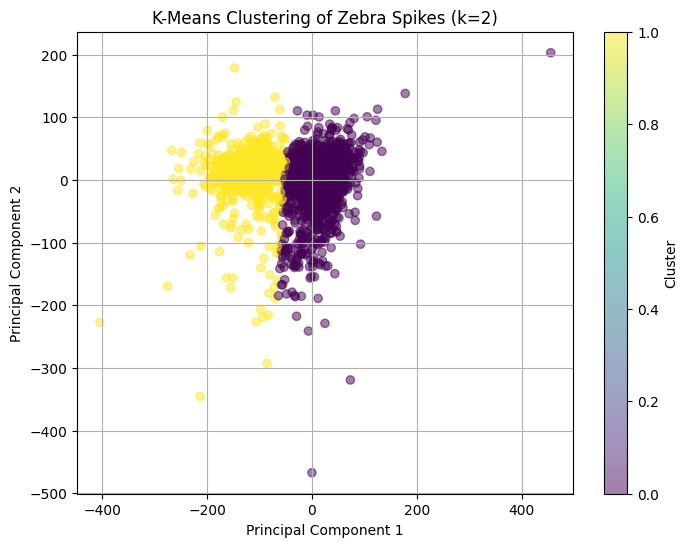

In [ ]:
zebra_kmeans = KMeans(n_clusters=2)
zebra_kmeans.fit(zebra_peaks_array)
zebra_kmeans_labels = zebra_kmeans.predict(zebra_peaks_array)
print(zebra_kmeans_labels)

plt.figure(figsize=(8, 6))
plt.scatter(zebra_pca_result[:, 0], zebra_pca_result[:, 1], c=zebra_kmeans_labels, cmap='viridis', alpha=0.5)
plt.title('K-Means Clustering of Zebra Spikes (k=2)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

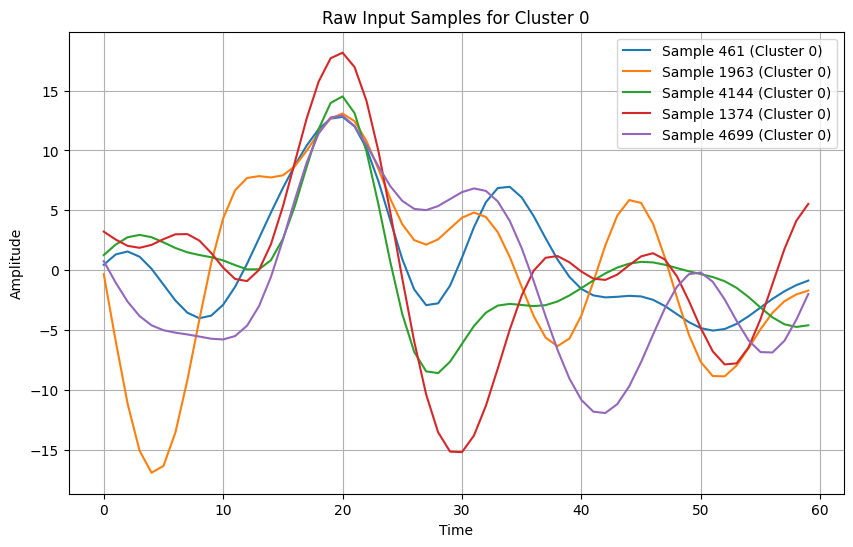

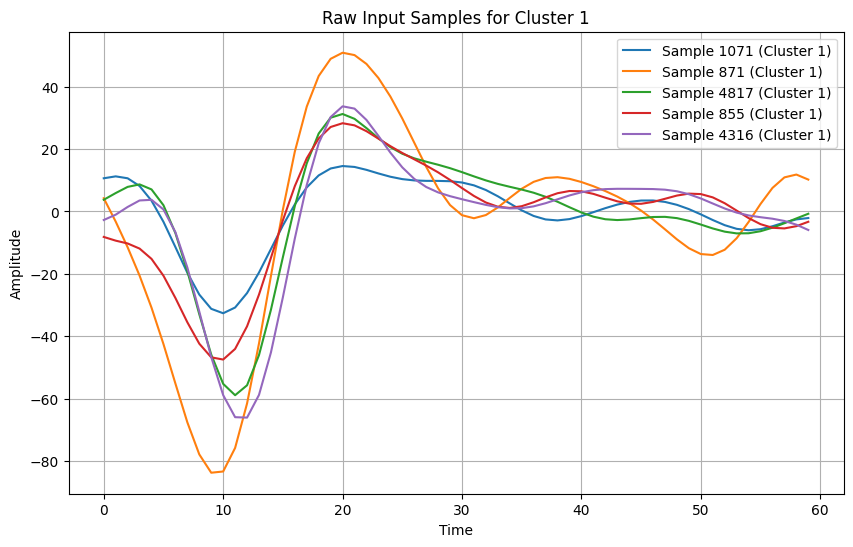

In [ ]:
n_samples = 5

for cluster_label in np.unique(zebra_kmeans_labels):
    cluster_indices = np.where(zebra_kmeans_labels == cluster_label)[0]
    sample_indices = np.random.choice(cluster_indices, size=min(n_samples, len(cluster_indices)), replace=False)

    plt.figure(figsize=(10, 6))
    for index in sample_indices:
        plt.plot(zebra_peaks_array[index], label=f"Sample {index} (Cluster {cluster_label})")

    plt.title(f"Raw Input Samples for Cluster {cluster_label}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()

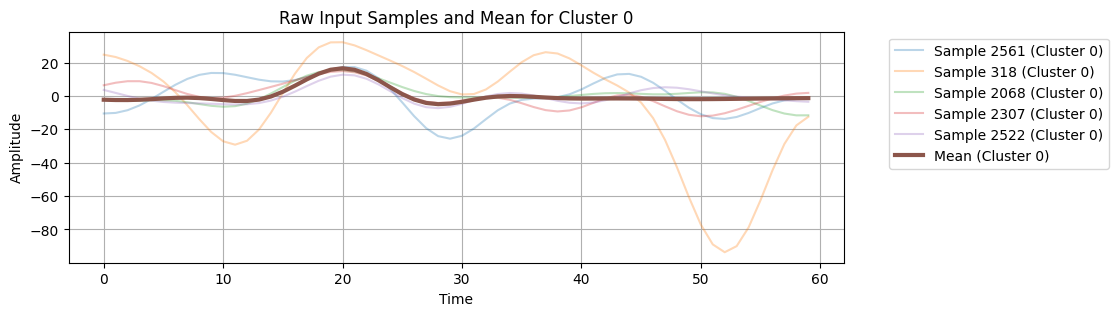

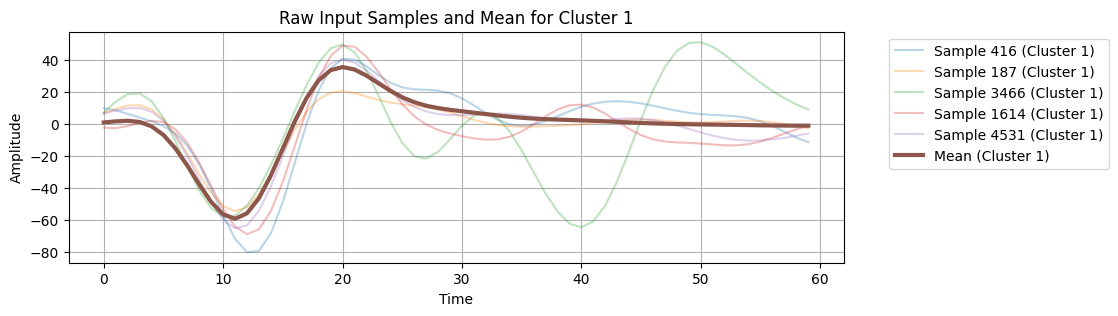

In [ ]:
zebra_cluster_means = []
for cluster_label in np.unique(zebra_kmeans_labels):
    cluster_indices = np.where(zebra_kmeans_labels == cluster_label)[0]
    cluster_data = zebra_peaks_array[cluster_indices]
    cluster_mean = np.mean(cluster_data, axis=0)
    zebra_cluster_means.append(cluster_mean)


n_samples = 5

for cluster_label in np.unique(zebra_kmeans_labels):
    cluster_indices = np.where(zebra_kmeans_labels == cluster_label)[0]
    sample_indices = np.random.choice(cluster_indices, size=min(n_samples, len(cluster_indices)), replace=False)

    plt.figure(figsize=(10, 3))
    for index in sample_indices:
        plt.plot(zebra_peaks_array[index], label=f"Sample {index} (Cluster {cluster_label})", alpha = 0.3)

    plt.plot(zebra_cluster_means[cluster_label], label=f"Mean (Cluster {cluster_label})", linewidth=3)

    plt.title(f"Raw Input Samples and Mean for Cluster {cluster_label}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

#### spike data

[2, 2, 2, 2, 2, 0, 2, 2, 0, 1, 1, 2, 2, 2, 2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 0, 1, 2, 2, 1, 2, 1, 1, 2, 2, 2, 0, 2, 2, 0, 2, 1, 2, 0, 0, 2, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 2, 2, 0, 2, 1, 2, 0, 2, 0, 2, 2, 2, 2, 1, 2, 1, 2, 2, 1, 1, 1, 2, 2, 1, 2, 2, 2, 2, 2, 0, 2, 2, 1, 2, 0, 2, 2, 2, 2, 1, 2, 2, 2, 0, 2, 2, 1, 2, 0, 2, 2, 2, 2, 0, 0, 1, 2, 2, 0, 2, 2, 2, 0, 2, 1, 2, 0, 1, 0, 2, 1, 1, 2, 1, 0, 2, 1, 2, 2, 2, 2, 2, 1, 2, 2, 0, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 1, 2, 0, 2, 2, 2, 2, 0, 2, 2, 2, 2, 2, 1, 1, 0, 2, 2, 0, 1, 0, 2, 1, 1, 0, 2, 0, 2, 0, 1, 2, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 0, 1, 2, 2, 2, 0, 2, 0, 1, 2, 2, 2, 2, 0, 2, 2, 2, 1, 2, 2, 2, 1, 2, 2, 0, 2, 2, 0, 0, 2, 1, 1, 0, 2, 0, 2, 2, 2, 2, 2, 2, 2, 2, 1, 2, 2, 0, 1, 2, 2, 1, 1, 1, 2, 2, 0, 2, 2, 2, 0, 2, 0, 2, 1, 2, 0, 0, 2, 1, 2, 1, 2, 2, 2, 2, 2, 1, 0, 0, 2, 0, 2, 2, 2, 2, 1, 2, 2, 0, 2, 1, 2, 2, 1, 1, 2, 2, 0, 0, 2, 2, 0, 1, 2, 2, 2, 0, 2, 1, 2, 0, 2, 0, 2, 1, 1, 2, 1, 2, 2, 0, 2, 2, 2, 2, 2, 2, 2, 0, 

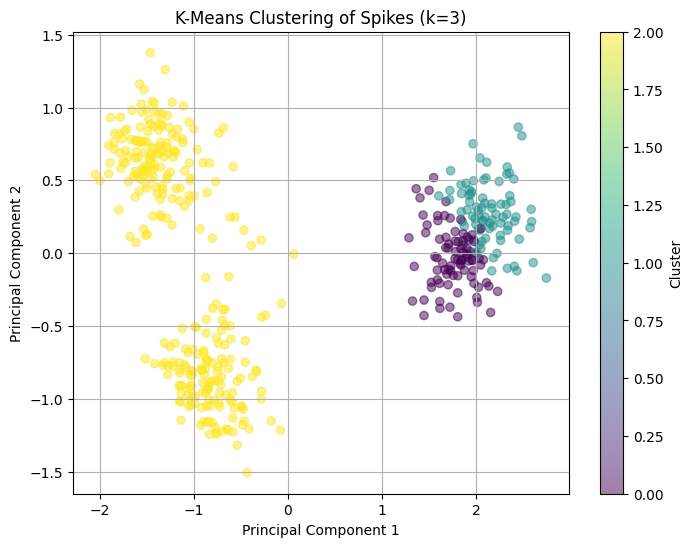

In [ ]:
spike_kmeans = KMeans(n_clusters=3)
spike_kmeans.fit(spikes_raw_data)
spike_kmeans_labels = spike_kmeans.predict(spikes_raw_data)
print(spike_kmeans_labels)

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=spike_kmeans_labels, cmap='viridis', alpha=0.5)
plt.title('K-Means Clustering of Spikes (k=3)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

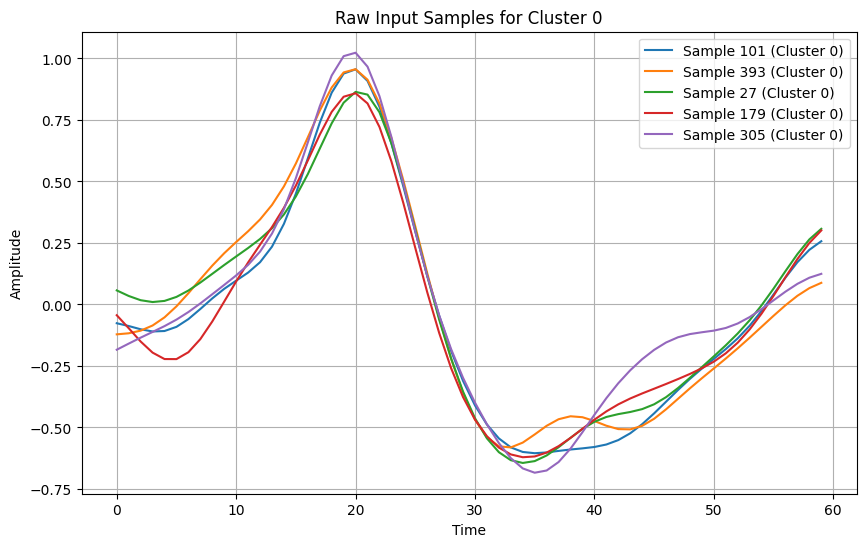

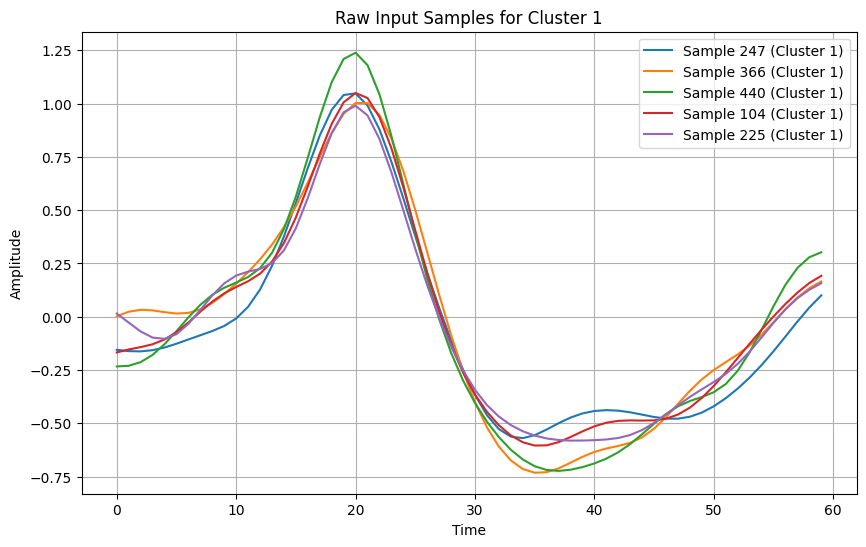

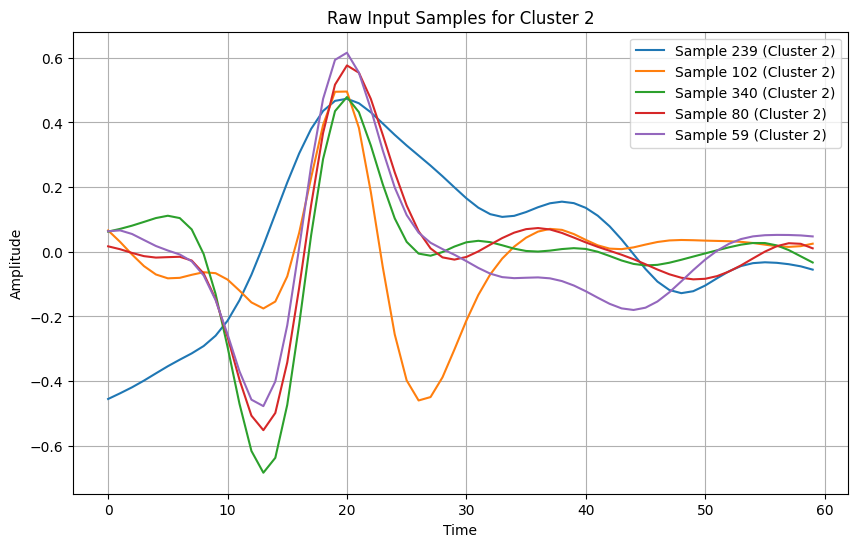

In [ ]:
n_samples = 5

for cluster_label in np.unique(spike_kmeans_labels):
    cluster_indices = np.where(spike_kmeans_labels == cluster_label)[0]
    sample_indices = np.random.choice(cluster_indices, size=min(n_samples, len(cluster_indices)), replace=False)

    plt.figure(figsize=(10, 6))
    for index in sample_indices:
        plt.plot(spikes_raw_data[index], label=f"Sample {index} (Cluster {cluster_label})")

    plt.title(f"Raw Input Samples for Cluster {cluster_label}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.grid(True)
    plt.show()

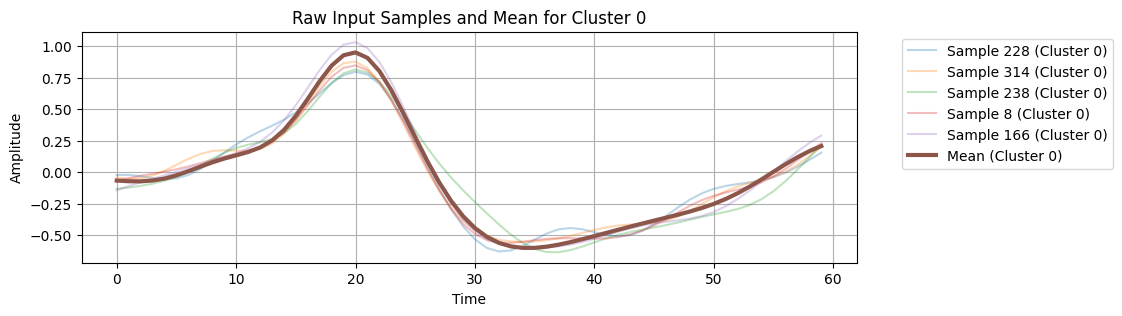

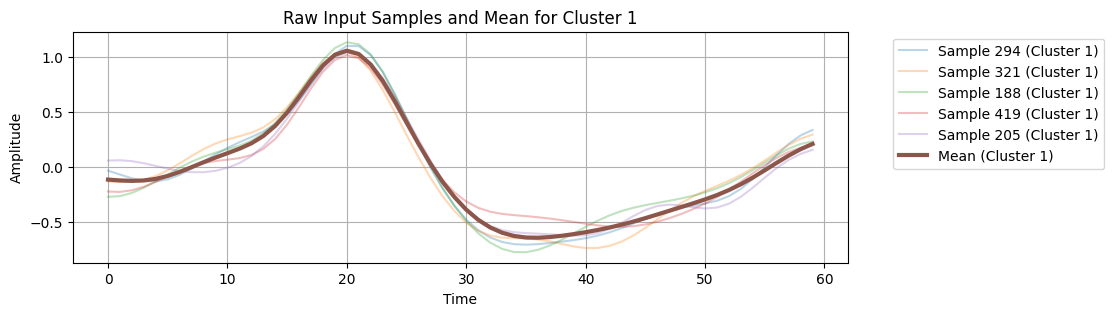

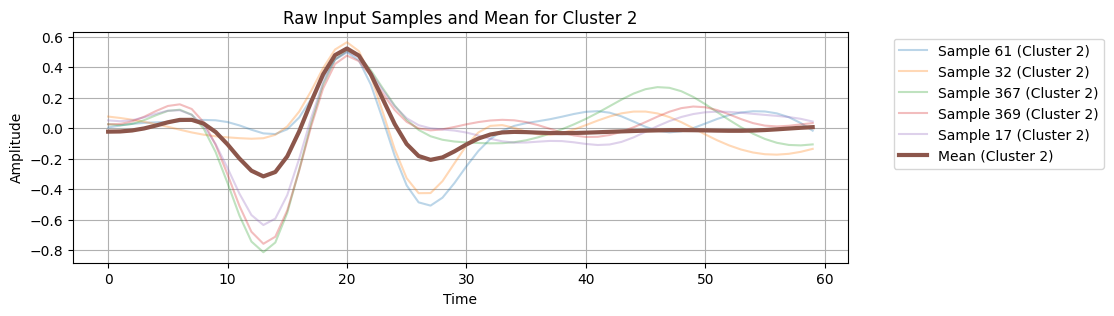

In [ ]:
cluster_means = []
for cluster_label in np.unique(spike_kmeans_labels):
    cluster_indices = np.where(spike_kmeans_labels == cluster_label)[0]
    cluster_data = spikes_raw_data[cluster_indices]
    cluster_mean = np.mean(cluster_data, axis=0)
    cluster_means.append(cluster_mean)


n_samples = 5

for cluster_label in np.unique(spike_kmeans_labels):
    cluster_indices = np.where(spike_kmeans_labels == cluster_label)[0]
    sample_indices = np.random.choice(cluster_indices, size=min(n_samples, len(cluster_indices)), replace=False)

    plt.figure(figsize=(10, 3))
    for index in sample_indices:
        plt.plot(spikes_raw_data[index], label=f"Sample {index} (Cluster {cluster_label})", alpha = 0.3)

    plt.plot(cluster_means[cluster_label], label=f"Mean (Cluster {cluster_label})", linewidth=3)

    plt.title(f"Raw Input Samples and Mean for Cluster {cluster_label}")
    plt.xlabel("Time")
    plt.ylabel("Amplitude")
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True)
    plt.show()

### SOM

In [ ]:
from tqdm import tqdm

class SOM:
    def __init__(self, m, n, dim, n_iterations=100, alpha=None, sigma=None):
        self.m = m
        self.n = n
        self.dim = dim
        self.n_iterations = n_iterations
        self.alpha = alpha if alpha is not None else 0.3
        self.sigma = sigma if sigma is not None else max(m, n) / 2
        self.weights = np.random.rand(m * n, dim)

    def fit(self, data):
        for i in tqdm(range(self.n_iterations)):
            self.alpha = self.alpha * (1 - i / self.n_iterations)
            self.sigma = self.sigma * (1 - i / self.n_iterations)

            for x in data:
                bmu_index = self.find_bmu(x)

                for j in range(self.m * self.n):
                    dist = np.linalg.norm(np.array([j // self.n, j % self.n]) - np.array([bmu_index // self.n, bmu_index % self.n]))
                    influence = np.exp(-dist**2 / (2 * self.sigma**2))
                    self.weights[j] += self.alpha * influence * (x - self.weights[j])

    def find_bmu(self, x):
        distances = np.linalg.norm(self.weights - x, axis=1)
        return np.argmin(distances)

    def predict(self, data):
        return np.array([self.find_bmu(x) for x in data])

#### zebra data

100%|██████████| 10/10 [00:04<00:00,  2.27it/s]


[0 0 0 ... 0 1 0]


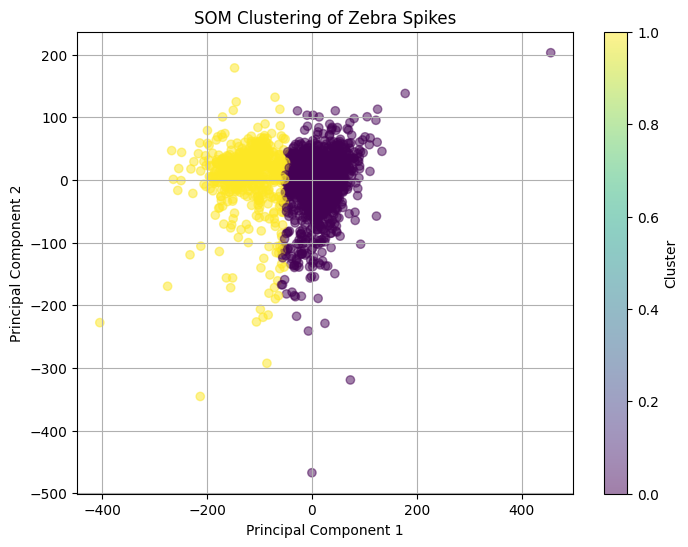

In [ ]:
som_zebra = SOM(m=2, n=1, dim=zebra_peaks_array.shape[1], n_iterations=10)
som_zebra.fit(zebra_peaks_array)
zebra_som_labels = som_zebra.predict(zebra_peaks_array)
print(zebra_som_labels)

plt.figure(figsize=(8, 6))
plt.scatter(zebra_pca_result[:, 0], zebra_pca_result[:, 1], c=zebra_som_labels, cmap='viridis', alpha=0.5)
plt.title('SOM Clustering of Zebra Spikes')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

#### spike data

100%|██████████| 10/10 [00:01<00:00,  9.78it/s]


[2 2 2 1 1 0 2 1 0 0 0 2 2 1 1 0 1 2 1 0 2 2 1 0 2 0 2 0 0 2 2 0 1 0 0 1 1
 1 0 2 1 0 1 0 1 0 0 1 2 0 2 1 2 2 2 0 2 1 1 2 0 1 0 1 0 2 0 1 2 1 1 0 1 0
 1 1 0 0 0 2 2 0 2 1 2 1 1 0 2 2 0 1 0 1 2 1 1 0 2 1 2 0 1 2 0 1 0 2 1 2 1
 0 0 0 2 1 0 1 2 1 0 2 0 2 0 0 0 2 0 0 1 0 0 1 0 2 1 1 2 2 0 1 2 0 1 0 0 2
 2 0 1 2 1 2 1 2 1 2 0 0 2 0 2 2 2 2 0 1 2 1 2 1 0 0 0 1 2 0 0 0 2 0 0 0 2
 0 1 0 0 2 1 2 0 1 2 1 2 2 1 1 1 1 1 0 0 0 2 2 2 0 2 0 0 2 2 1 1 0 1 1 2 0
 1 2 1 0 1 1 0 1 2 0 0 2 0 0 0 2 0 2 2 1 2 2 2 2 2 0 1 1 0 0 1 1 0 0 0 1 1
 0 2 1 1 0 1 0 2 0 2 0 0 1 0 2 0 1 2 2 2 1 0 0 0 2 0 2 1 1 2 0 1 2 0 1 0 2
 2 0 0 2 2 0 0 2 1 0 0 2 1 2 0 1 0 1 0 2 0 2 0 0 2 0 1 2 0 1 1 2 1 1 1 1 0
 1 1 2 2 1 0 2 2 1 2 2 2 2 0 0 2 0 0 0 2 1 2 2 1 0 2 0 1 2 2 2 1 2 0 2 2 2
 1 1 2 1 1 0 1 2 1 1 0 0 1 1 0 0 2 2 2 0 1 1 2 0 0 2 1 2 1 1 2 1 1 2 2 0 0
 1 1 2 2 0 0 0 0 1 2 0 1 0 0 2 1 1 0 1 0 2 1 0 2 2 0 2 2 2 0 0 1 0 0 0 0 1
 0 2 0 1 0 1 1 0 0 0 1 1 2 1 1 1]


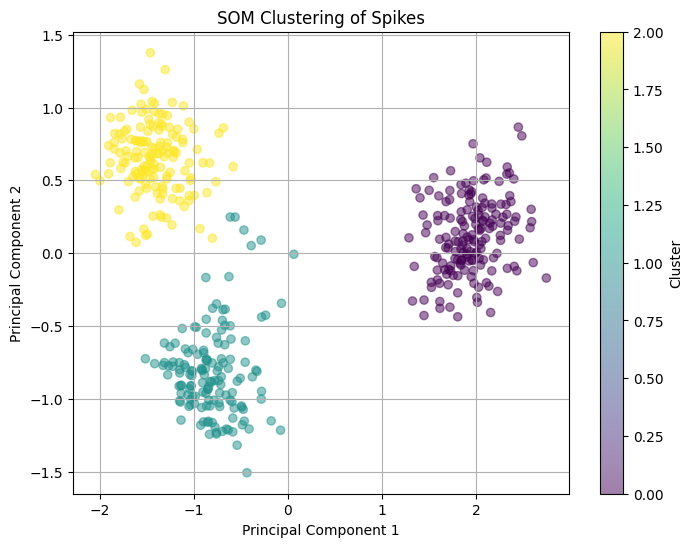

In [ ]:
som_spike = SOM(m=3, n=1, dim=spikes_raw_data.shape[1], n_iterations=10)
som_spike.fit(spikes_raw_data)
spike_som_labels = som_spike.predict(spikes_raw_data)
print(spike_som_labels)

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=spike_som_labels, cmap='viridis', alpha=0.5)
plt.title('SOM Clustering of Spikes')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

### Hierarchical Clustering

In [61]:
import numpy as np
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import linkage, fcluster

class HierarchicalClusteringDivisive:
    def __init__(self, n_clusters):
        self.n_clusters = n_clusters

    def fit(self, X):
        distances = pdist(X)
        distance_matrix = squareform(distances)

        linkage_matrix = linkage(distance_matrix, method='ward')

        self.labels_ = fcluster(linkage_matrix, t=self.n_clusters, criterion='maxclust')
        return self

    def predict(self, X):
      distances = pdist(np.vstack([self.X_, X]))
      distance_matrix = squareform(distances)

      new_labels = []
      for i in range(len(X)):
        closest_point_index = np.argmin(distance_matrix[len(self.X_):, :len(self.X_)][i])
        new_labels.append(self.labels_[closest_point_index])

      return np.array(new_labels)

    def fit_predict(self, X):
        self.X_ = X
        self.fit(X)
        return self.labels_

#### zebra data

<ipython-input-61-3323d9b92ceb>:13: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method='ward')


[2 2 1 ... 1 2 1]


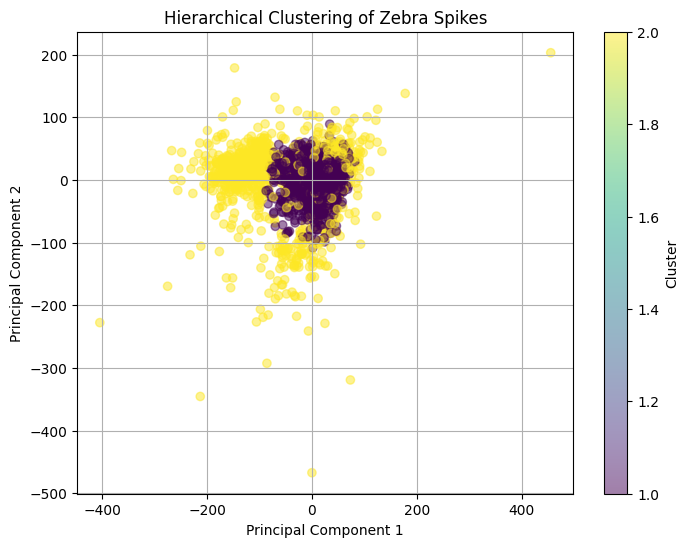

In [64]:
zebra_hc = HierarchicalClusteringDivisive(n_clusters=2)
zebra_hc_labels = zebra_hc.fit_predict(zebra_peaks_array)
print(zebra_hc_labels)

plt.figure(figsize=(8, 6))
plt.scatter(zebra_pca_result[:, 0], zebra_pca_result[:, 1], c=zebra_hc_labels, cmap='viridis', alpha=0.5)
plt.title('Hierarchical Clustering of Zebra Spikes')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

#### spike data


<ipython-input-61-3323d9b92ceb>:13: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  linkage_matrix = linkage(distance_matrix, method='ward')


[2 2 2 3 3 1 2 3 1 1 1 2 2 3 3 1 3 2 3 1 2 2 3 1 2 1 2 1 1 2 2 1 3 1 1 3 3
 3 1 2 3 1 3 1 3 1 1 3 2 1 2 3 2 2 2 1 2 3 3 2 1 3 1 3 1 2 1 3 2 3 3 1 3 1
 3 3 1 1 1 2 2 1 2 3 2 3 3 1 2 2 1 3 1 3 2 3 3 1 2 3 2 1 3 2 1 3 1 2 3 2 3
 1 1 1 2 3 1 3 2 3 1 2 1 2 1 1 1 2 1 1 3 1 1 3 1 3 3 3 2 2 1 3 2 1 3 1 1 2
 2 1 3 2 3 2 3 2 3 2 1 1 2 1 2 2 2 2 1 3 2 3 2 3 1 1 1 3 2 1 1 1 2 1 1 1 2
 1 3 1 1 2 3 2 1 3 2 3 2 2 3 3 3 3 3 1 1 1 2 2 2 1 2 1 1 2 2 3 3 1 3 3 2 1
 3 2 3 1 3 3 1 3 2 1 1 2 1 1 1 2 1 3 2 3 2 2 2 2 2 1 3 3 1 1 3 3 1 1 1 3 3
 1 2 3 3 1 3 1 2 1 2 1 1 3 1 2 1 3 2 2 2 3 1 1 1 2 1 2 3 3 2 1 3 2 1 3 1 2
 2 1 1 2 2 1 1 2 3 1 1 2 3 2 1 3 1 3 1 2 1 2 1 1 2 1 3 2 1 3 3 2 3 3 3 3 1
 3 3 2 2 3 1 2 2 3 2 2 2 2 1 1 2 1 1 1 3 3 2 2 3 1 2 1 3 2 2 2 3 2 1 2 2 2
 3 3 2 3 3 1 3 2 3 3 1 1 3 3 1 1 2 2 2 1 3 3 2 1 1 2 3 2 3 3 2 3 3 2 2 1 1
 3 3 2 2 1 1 1 1 3 2 1 3 1 1 2 3 3 1 3 1 2 3 1 2 2 1 2 2 2 1 1 3 1 1 1 1 3
 1 2 1 3 1 3 3 1 1 1 3 3 2 3 3 3]


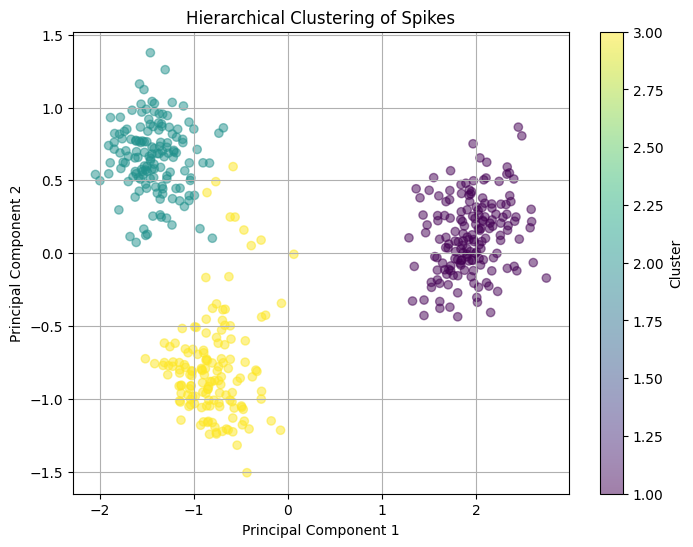

In [63]:
spike_hc = HierarchicalClusteringDivisive(n_clusters=3)
spike_hc_labels = spike_hc.fit_predict(spikes_raw_data)
print(spike_hc_labels)

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=spike_hc_labels, cmap='viridis', alpha=0.5)
plt.title('Hierarchical Clustering of Spikes')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

### Cmeans

In [65]:
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 33.6 MB/s eta 0:00:00


#### zebra data

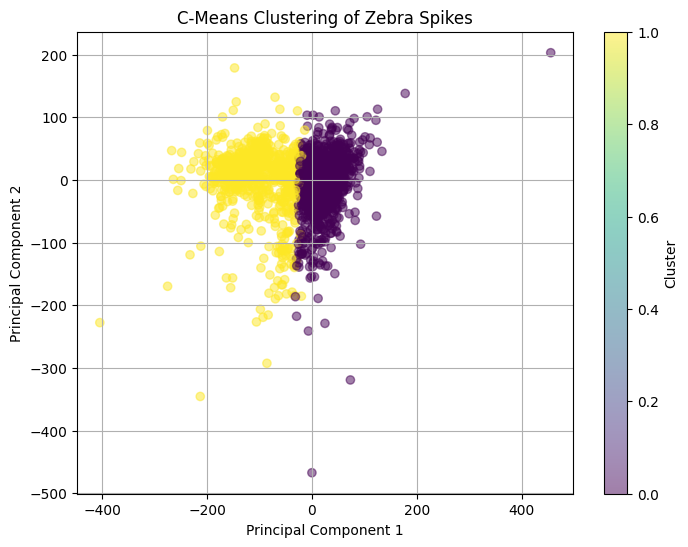

Cluster Centers:
[[-1.88265721e+00 -1.94241606e+00 -1.88129836e+00 -1.67295044e+00
  -1.34387525e+00 -9.79294251e-01 -7.05795348e-01 -6.51305876e-01
  -8.92145138e-01 -1.40414984e+00 -2.03687550e+00 -2.52511792e+00
  -2.54148687e+00 -1.78076011e+00 -5.54276295e-02  2.62423562e+00
   6.01107150e+00  9.63989201e+00  1.29070276e+01  1.51966163e+01
   1.60248448e+01  1.51648619e+01  1.27163496e+01  9.09593883e+00
   4.94576561e+00  9.82019530e-01 -2.17471144e+00 -4.13813483e+00
  -4.82425773e+00 -4.43266462e+00 -3.35397896e+00 -2.03919379e+00
  -8.74821262e-01 -9.99056235e-02  2.18168913e-01  1.53904010e-01
  -1.39016516e-01 -4.96386633e-01 -7.95509708e-01 -9.78980176e-01
  -1.05078309e+00 -1.05412520e+00 -1.04366366e+00 -1.06282817e+00
  -1.13194287e+00 -1.24753413e+00 -1.38951261e+00 -1.53152566e+00
  -1.65031884e+00 -1.73156854e+00 -1.77150362e+00 -1.77511608e+00
  -1.75256375e+00 -1.71544099e+00 -1.67408095e+00 -1.63624920e+00
  -1.60687924e+00 -1.58820179e+00 -1.57980612e+00 -1.578619

In [102]:
import skfuzzy as fuzz
from skfuzzy import control as ctrl

n_clusters = 2

cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    zebra_peaks_array.T, n_clusters, 2, error=0.005, maxiter=1000
)

zebra_cluster_membership = np.argmax(u, axis=0)

plt.figure(figsize=(8, 6))
plt.scatter(zebra_pca_result[:, 0], zebra_pca_result[:, 1], c=zebra_cluster_membership, cmap='viridis', alpha=0.5)
plt.title('C-Means Clustering of Zebra Spikes')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

print("Cluster Centers:")
print(cntr)

print(f"Fuzzy Partition Coefficient (FPC): {fpc}")

#### spike data

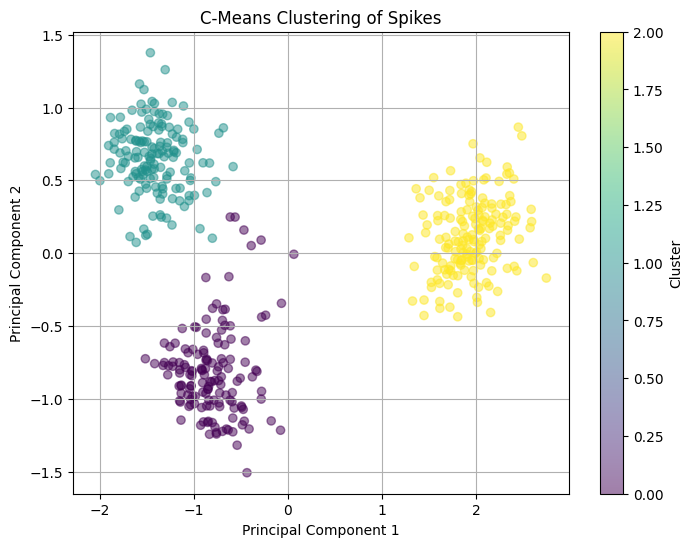

Cluster Centers:
[[-1.22908868e-02 -1.11031232e-02 -8.62142492e-03 -3.93072854e-03
   3.70063678e-03  1.43821646e-02  2.71334866e-02  3.95884715e-02
   4.81484289e-02  4.88258534e-02  3.88149773e-02  1.84860310e-02
  -6.86042269e-03 -2.63872643e-02 -2.51662555e-02  1.17956553e-02
   9.32419970e-02  2.14623345e-01  3.53405934e-01  4.70814452e-01
   5.22812261e-01  4.78127714e-01  3.34613219e-01  1.23407908e-01
  -1.02899365e-01 -2.91397747e-01 -4.07413125e-01 -4.42298111e-01
  -4.09919176e-01 -3.36618764e-01 -2.50321986e-01 -1.72612692e-01
  -1.15202015e-01 -8.03517206e-02 -6.37768110e-02 -5.83135626e-02
  -5.70127102e-02 -5.49832202e-02 -4.99424169e-02 -4.18233073e-02
  -3.19160125e-02 -2.19544849e-02 -1.34117340e-02 -7.11880199e-03
  -3.20522890e-03 -1.27250100e-03 -6.64784037e-04 -7.07468466e-04
  -8.37932186e-04 -6.24015509e-04  2.80155420e-04  2.17290493e-03
   5.28699097e-03  9.70497291e-03  1.52502596e-02  2.14343735e-02
   2.75299046e-02  3.27668055e-02  3.65645931e-02  3.868813

In [103]:
n_clusters = 3

cntr, u, u0, d, jm, p, fpc = fuzz.cluster.cmeans(
    spikes_raw_data.T, n_clusters, 2, error=0.005, maxiter=1000
)

spike_cluster_membership = np.argmax(u, axis=0)

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=spike_cluster_membership, cmap='viridis', alpha=0.5)
plt.title('C-Means Clustering of Spikes')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

print("Cluster Centers:")
print(cntr)

print(f"Fuzzy Partition Coefficient (FPC): {fpc}")

### DBSCAN

In [86]:
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler

#### zebra data

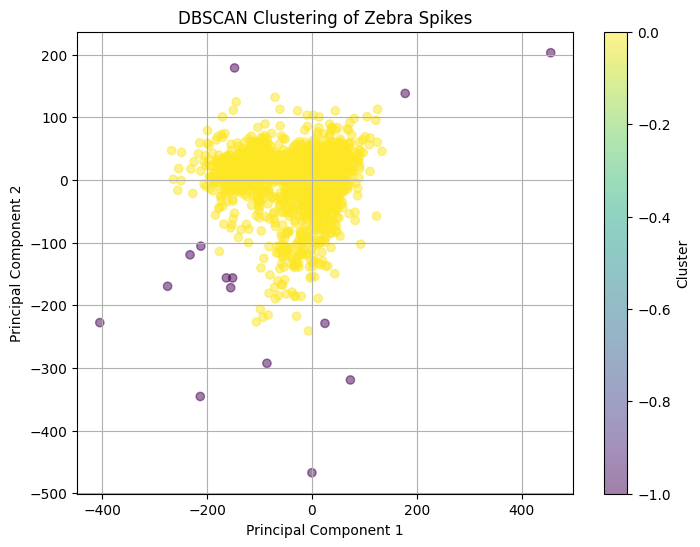

Estimated number of clusters: 1
Estimated number of noise points: 15


In [85]:
scaler = StandardScaler()
zebra_peaks_array_scaled = scaler.fit_transform(zebra_pca_result)

dbscan = DBSCAN(eps=1, min_samples=6)
zebra_dbscan_labels = dbscan.fit_predict(zebra_peaks_array_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(zebra_pca_result[:, 0], zebra_pca_result[:, 1], c=zebra_dbscan_labels, cmap='viridis', alpha=0.5)
plt.title('DBSCAN Clustering of Zebra Spikes')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

n_clusters_ = len(set(zebra_dbscan_labels)) - (1 if -1 in zebra_dbscan_labels else 0)
n_noise_ = list(zebra_dbscan_labels).count(-1)
print(f"Estimated number of clusters: {n_clusters_}")
print(f"Estimated number of noise points: {n_noise_}")

#### spike data

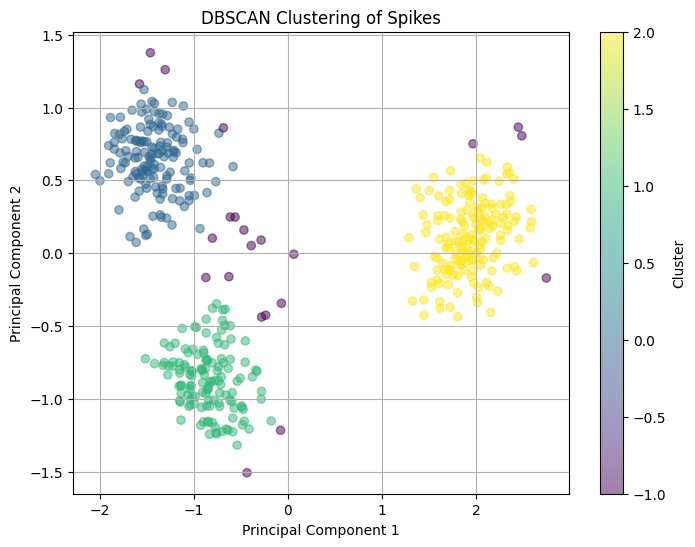

Estimated number of clusters: 3
Estimated number of noise points: 22


In [82]:
scaler = StandardScaler()
spikes_raw_data_scaled = scaler.fit_transform(pca_result)

dbscan = DBSCAN(eps=0.2, min_samples=6)
spike_dbscan_labels = dbscan.fit_predict(spikes_raw_data_scaled)

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=spike_dbscan_labels, cmap='viridis', alpha=0.5)
plt.title('DBSCAN Clustering of Spikes')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

n_clusters_ = len(set(spike_dbscan_labels)) - (1 if -1 in spike_dbscan_labels else 0)
n_noise_ = list(spike_dbscan_labels).count(-1)
print(f"Estimated number of clusters: {n_clusters_}")
print(f"Estimated number of noise points: {n_noise_}")

### Distribution-based clustering

In [87]:
import numpy as np
from scipy.stats import gaussian_kde

In [88]:
def distribution_based_clustering(data, n_clusters, bandwidth=0.5):
    kde = gaussian_kde(data.T, bw_method=bandwidth)
    density_values = kde(data.T)

    peak_indices = find_peaks(density_values, distance=len(data) // (2*n_clusters))[0]

    if len(peak_indices) < n_clusters:
      peak_indices = np.argsort(density_values)[-n_clusters:]
      peak_indices = peak_indices[::-1]


    cluster_centers = data[peak_indices]

    cluster_labels = np.zeros(len(data))
    for i, point in enumerate(data):
        distances = np.linalg.norm(cluster_centers - point, axis=1)
        cluster_labels[i] = np.argmin(distances)

    return cluster_labels

#### zebra data

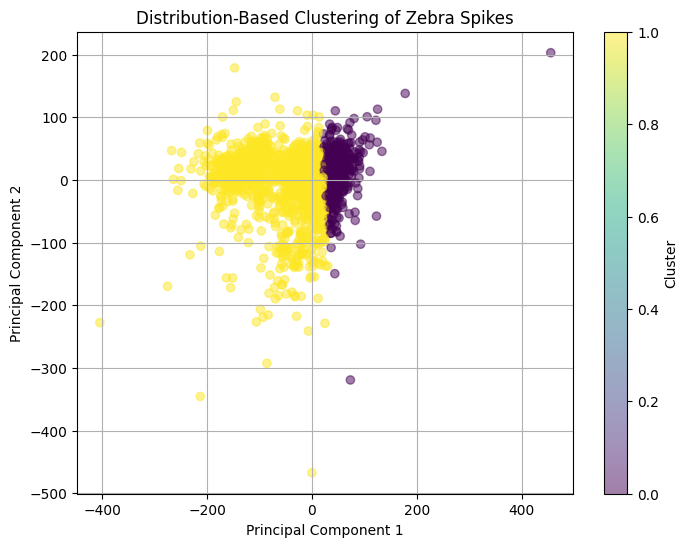

In [91]:
zebra_dist_labels = distribution_based_clustering(zebra_pca_result, n_clusters=1, bandwidth=0.3)

plt.figure(figsize=(8, 6))
plt.scatter(zebra_pca_result[:, 0], zebra_pca_result[:, 1], c=zebra_dist_labels, cmap='viridis', alpha=0.5)
plt.title('Distribution-Based Clustering of Zebra Spikes')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

#### spike data

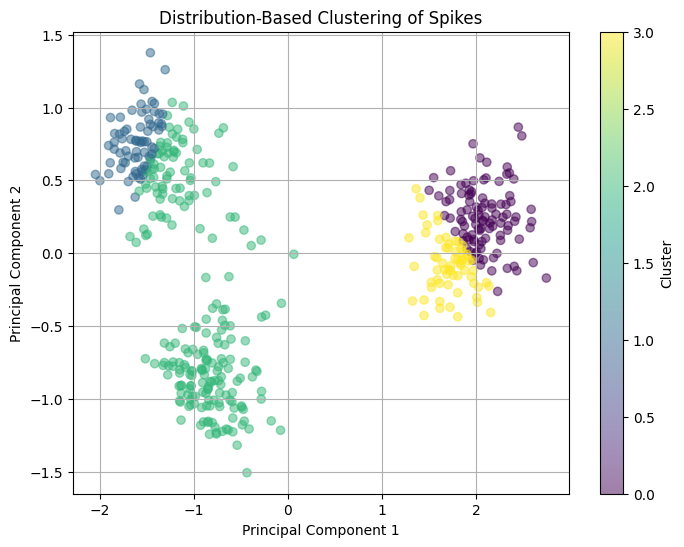

In [95]:
spike_dist_labels = distribution_based_clustering(pca_result, n_clusters=2, bandwidth=0.05)

plt.figure(figsize=(8, 6))
plt.scatter(pca_result[:, 0], pca_result[:, 1], c=spike_dist_labels, cmap='viridis', alpha=0.5)
plt.title('Distribution-Based Clustering of Spikes')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster')
plt.grid(True)
plt.show()

## Validation

In [96]:
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score

def evaluate_clustering(data, labels):
    metrics = {}
    metrics['Silhouette Score'] = silhouette_score(data, labels)
    metrics['Calinski-Harabasz Index'] = calinski_harabasz_score(data, labels)
    metrics['Davies-Bouldin Index'] = davies_bouldin_score(data, labels)
    return metrics

In [104]:
# Evaluate Zebra Data
print("Zebra Data Clustering Evaluation:")
print("KMeans:")
print(evaluate_clustering(zebra_pca_result, zebra_kmeans_labels))
print("\nSOM:")
print(evaluate_clustering(zebra_pca_result, zebra_som_labels))
print("\nHierarchical Clustering:")
print(evaluate_clustering(zebra_pca_result, zebra_hc_labels))
print("\nC-Means:")
print(evaluate_clustering(zebra_pca_result, zebra_cluster_membership))
print("\nDBSCAN:")
print(evaluate_clustering(zebra_peaks_array_scaled, zebra_dbscan_labels))
print("\nDistribution-Based:")
print(evaluate_clustering(zebra_pca_result, zebra_dist_labels))

Zebra Data Clustering Evaluation:
KMeans:
{'Silhouette Score': 0.6946030867400809, 'Calinski-Harabasz Index': 6009.95912420689, 'Davies-Bouldin Index': 0.5460112671360933}

SOM:
{'Silhouette Score': 0.6933721148426432, 'Calinski-Harabasz Index': 6002.950431825288, 'Davies-Bouldin Index': 0.5611105023098156}

Hierarchical Clustering:
{'Silhouette Score': 0.5626296543295918, 'Calinski-Harabasz Index': 1810.800496922462, 'Davies-Bouldin Index': 1.4346411973662043}

C-Means:
{'Silhouette Score': 0.6519531958656094, 'Calinski-Harabasz Index': 5417.295551407087, 'Davies-Bouldin Index': 0.7092542213811982}

DBSCAN:
{'Silhouette Score': 0.8069941320022039, 'Calinski-Harabasz Index': 172.35633617499113, 'Davies-Bouldin Index': 1.3760978110411972}

Distribution-Based:
{'Silhouette Score': 0.1415385915036413, 'Calinski-Harabasz Index': 1269.9638713189668, 'Davies-Bouldin Index': 1.244593132973219}


In [105]:
# Evaluate Spike Data
print("\n\nSpike Data Clustering Evaluation:")
print("KMeans:")
print(evaluate_clustering(pca_result, spike_kmeans_labels))
print("\nSOM:")
print(evaluate_clustering(pca_result, spike_som_labels))
print("\nHierarchical Clustering:")
print(evaluate_clustering(pca_result, spike_hc_labels))
print("\nC-Means:")
print(evaluate_clustering(pca_result, spike_cluster_membership))
print("\nDBSCAN:")
print(evaluate_clustering(spikes_raw_data_scaled, spike_dbscan_labels))
print("\nDistribution-Based:")
print(evaluate_clustering(pca_result, spike_dist_labels))



Spike Data Clustering Evaluation:
KMeans:
{'Silhouette Score': 0.5318964146097507, 'Calinski-Harabasz Index': 942.9147189328025, 'Davies-Bouldin Index': 0.8338991283968552}

SOM:
{'Silhouette Score': 0.7428267260207759, 'Calinski-Harabasz Index': 3818.599079828229, 'Davies-Bouldin Index': 0.3670156293996754}

Hierarchical Clustering:
{'Silhouette Score': 0.7344215707243795, 'Calinski-Harabasz Index': 3621.750658814658, 'Davies-Bouldin Index': 0.37856941225881974}

C-Means:
{'Silhouette Score': 0.7428267260207759, 'Calinski-Harabasz Index': 3818.5990798282296, 'Davies-Bouldin Index': 0.3670156293996754}

DBSCAN:
{'Silhouette Score': 0.673209732189876, 'Calinski-Harabasz Index': 1123.9109613871149, 'Davies-Bouldin Index': 1.1496652748752214}

Distribution-Based:
{'Silhouette Score': 0.32327471476852204, 'Calinski-Harabasz Index': 1078.9736481368104, 'Davies-Bouldin Index': 0.9002272995079168}
